# TRABAJO GRUPAL ANÁLISIS MULTIVARIANTE
### Global poverty and inequality dataset

**Kaggle link**: https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset/data?select=pip_codebook.csv

Mapa del mundo coloreable: https://naturaldisasters.ai/posts/python-geopandas-world-map-tutorial/

### Tabla de Contenidos: <a class="anchor" id="index"></a>

<div class="alert" style="margin-top: 20px">

1. [Cargar datos e importar librerías](#seccion_1)<br>

2. [Análisis e imputación de datos perdidos](#seccion_2)<br>

3. [Análisis de correlaciones y reducción de la dimensionalidad](#seccion_3)<br>

4. [agdniaodgn](#seccion_4)<br>
</div>


### 1. Cargar datos e importar librerías <a class="anchor" id="seccion_1"></a>



In [18]:
# py -m pip install pandas
# py -m pip install numpy
# py -m pip install matplotlib
# py -m pip install plotly
# py -m pip install seaborn

In [19]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go
import plotly.subplots as sp

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from continents import continent_dict 

In [20]:
# Load the  dataset
# path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\Máster\\Cuatri A\\Análisis Multivariante\\'
path = 'C:\\Users\\carlo\\OneDrive\\Documentos\\GitHub\\Multivariante\\'
file_name = 'pip_dataset.csv'
data = pd.read_csv(path + file_name)

# Create continent column
data['continent'] = data['country'].map(continent_dict) # create column continet
data = data[['country', 'continent'] + [col for col in data.columns if col not in ['country', 'continent']]]
data.tail()

,country,continent,year,reporting_level,welfare_type,ppp_version,survey_year,survey_comparability,headcount_ratio_international_povline,headcount_ratio_lower_mid_income_povline,...,decile8_thr,decile9_thr,gini,mld,polarization,palma_ratio,s80_s20_ratio,p90_p10_ratio,p90_p50_ratio,p50_p10_ratio
4872,Zambia,Africa,2010,national,consumption,2017,2010.0,4.0,68.456606,82.885088,...,3.27,5.34,0.556215,0.539135,0.536149,4.278696,16.024650,10.470588,3.955556,2.647059
4873,Zambia,Africa,2015,national,consumption,2017,2015.0,4.0,61.352160,77.548045,...,4.02,6.43,0.571361,0.604667,0.613181,4.995829,21.243915,13.978261,4.095541,3.413043
4874,Zimbabwe,Africa,2011,national,consumption,2017,2011.0,0.0,21.580063,47.857143,...,7.25,10.54,0.431536,0.311153,0.388356,2.207938,8.526847,6.713376,2.773684,2.420382
4875,Zimbabwe,Africa,2017,national,consumption,2017,2017.0,0.0,34.206046,61.583570,...,5.96,8.81,0.443371,0.322848,0.416694,2.307359,8.569542,6.574627,3.069686,2.141791
4876,Zimbabwe,Africa,2019,national,consumption,2017,2019.0,0.0,39.754533,64.509857,...,5.76,9.01,0.502565,0.427862,0.463899,NaN,NaN,8.190909,3.400000,2.409091


In [21]:
# Filtrar y mostrar los valores únicos de los países cuyo continente es NaN
territories_with_nan_continent = data[data['continent'].isna()]['country'].unique()

# Mostrar los resultados
print("Territorios con continente NaN:")
print(territories_with_nan_continent)

Territorios con continente NaN:
['Congo' "Cote d'Ivoire" 'Czechia' 'Democratic Republic of Congo'
 'East Asia and Pacific' 'Europe and Central Asia' 'High income countries'
 'Kiribati' 'Latin America and the Caribbean' 'Micronesia (country)'
 'Middle East and North Africa' 'Montenegro' 'Sao Tome and Principe'
 'South Asia' 'Sub-Saharan Africa' 'Taiwan' 'Timor' 'World']


In [22]:
data.drop("survey_year", axis= 1, inplace=True)
feat_names = data.columns
feat_cat = list(feat_names[0:2]) + list(feat_names[3:5])
feat_num = [feat for feat in feat_names if feat not in feat_cat]

### 2. Análisis e imputación de datos perdidos <a class="anchor" id="seccion_2"></a>

Observar el porcentaje de datos perdidos por columna

C:\Users\carlo\AppData\Local\Temp\ipykernel_4820\4251843150.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, palette="viridis")


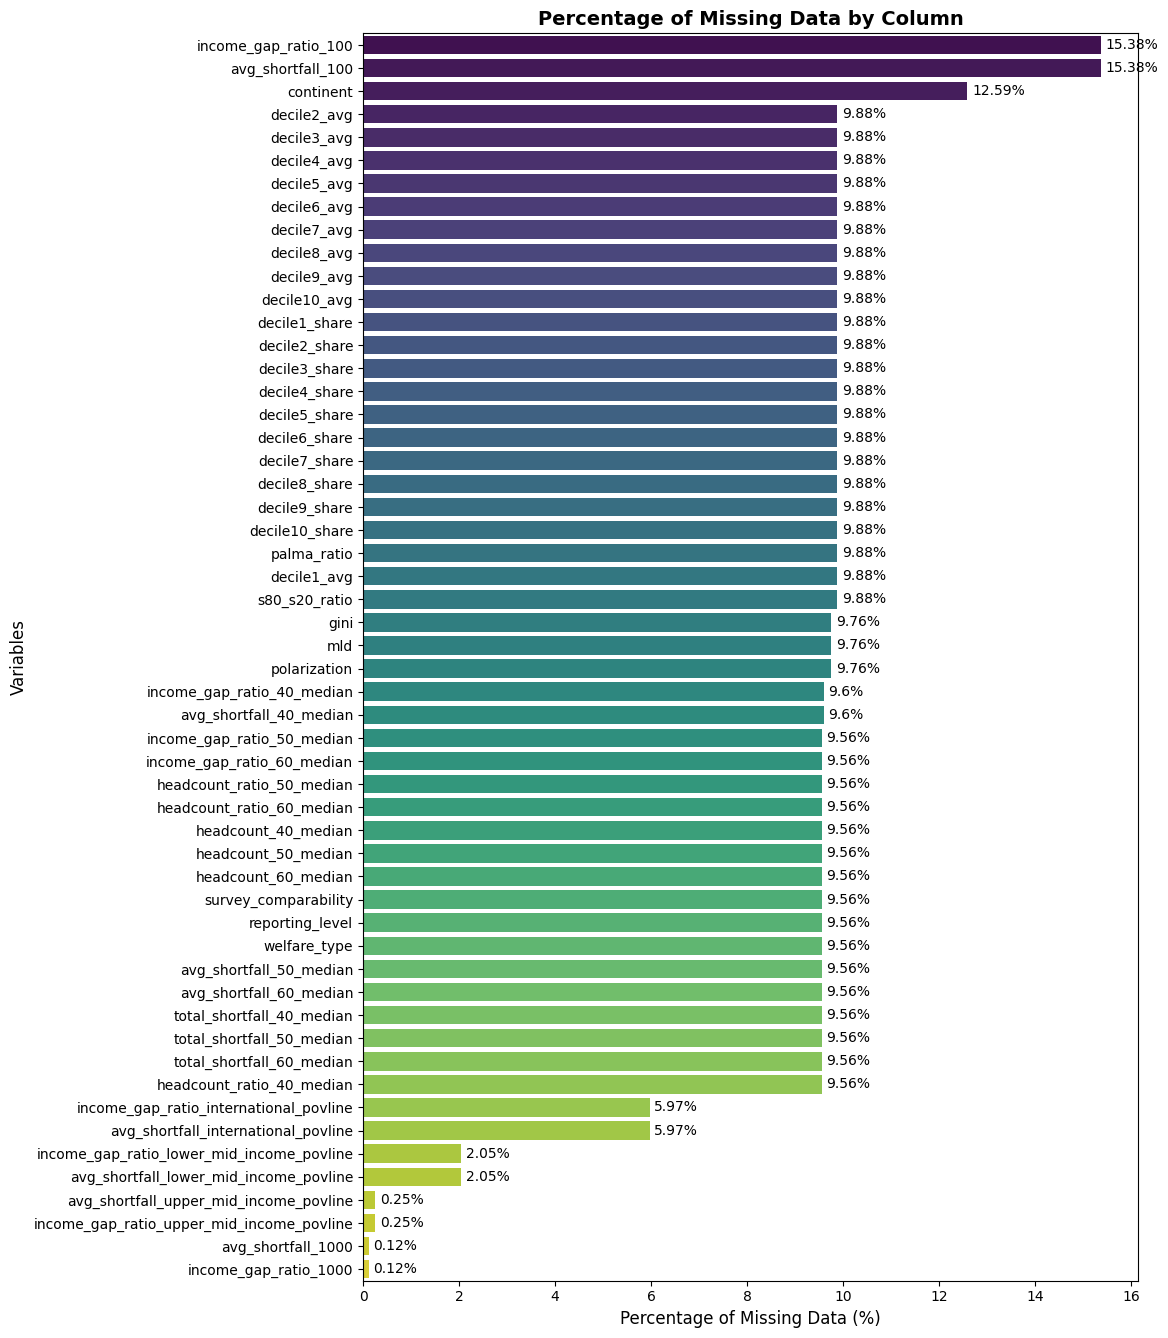

In [16]:
# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, palette="viridis")
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Eliminar los datos perdidos de los territorios poco claros (Worlwide, High income contries, Latin America and the Caribbean, ... ).

Number of rows with missing values: 482


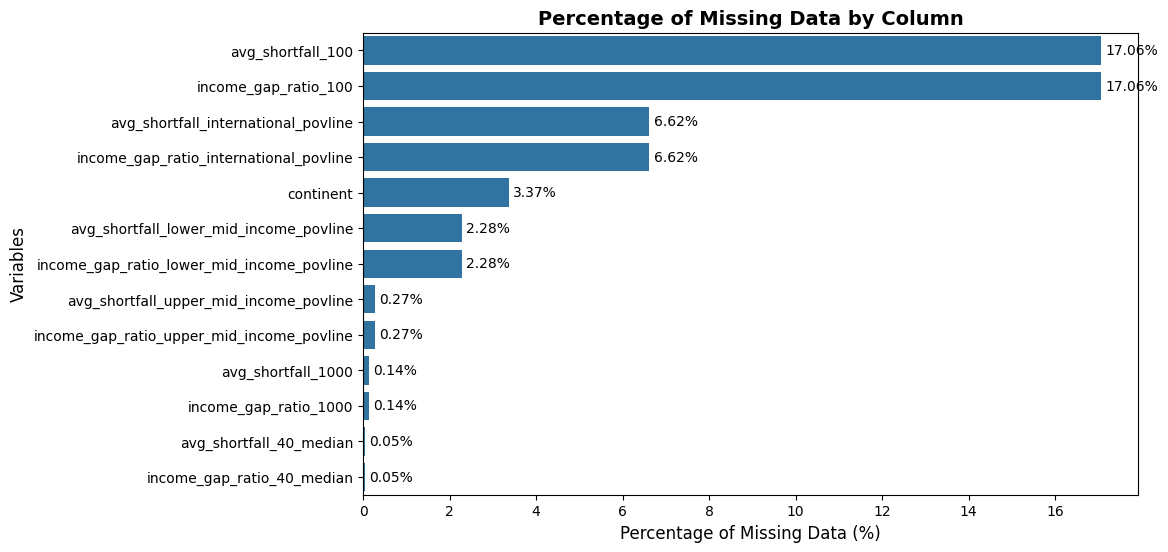

In [11]:
shape_1 = data.shape
data.dropna(subset=['reporting_level', 'welfare_type','decile10_share'], inplace=True)
shape_2 = data.shape
print(f"Number of rows with missing values: {shape_1[0] - shape_2[0]}")

# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table)
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Antes de imputar los datos perdidos restantes, solucionamos los outliers. Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.

In [45]:
data_headcount = data.iloc[:, 8:29]
data_avg_shortfall = data.iloc[:, 29:40]
data_total_shortfall = data.iloc[:, 40:51]
data_income_poverty_gap = data.iloc[:, 51:70]
data_decile = data.iloc[:, 70:100]
data_end = data.iloc[:, 100:109]

datasets = {
    'Headcount': data_headcount,
    'Average_Shortfall': data_avg_shortfall,
    'Total_Shortfall': data_total_shortfall,
    'Income_Poverty_Gap': data_income_poverty_gap,
    'Deciles': data_decile,
    'Inequality_Metrics': data_end
}

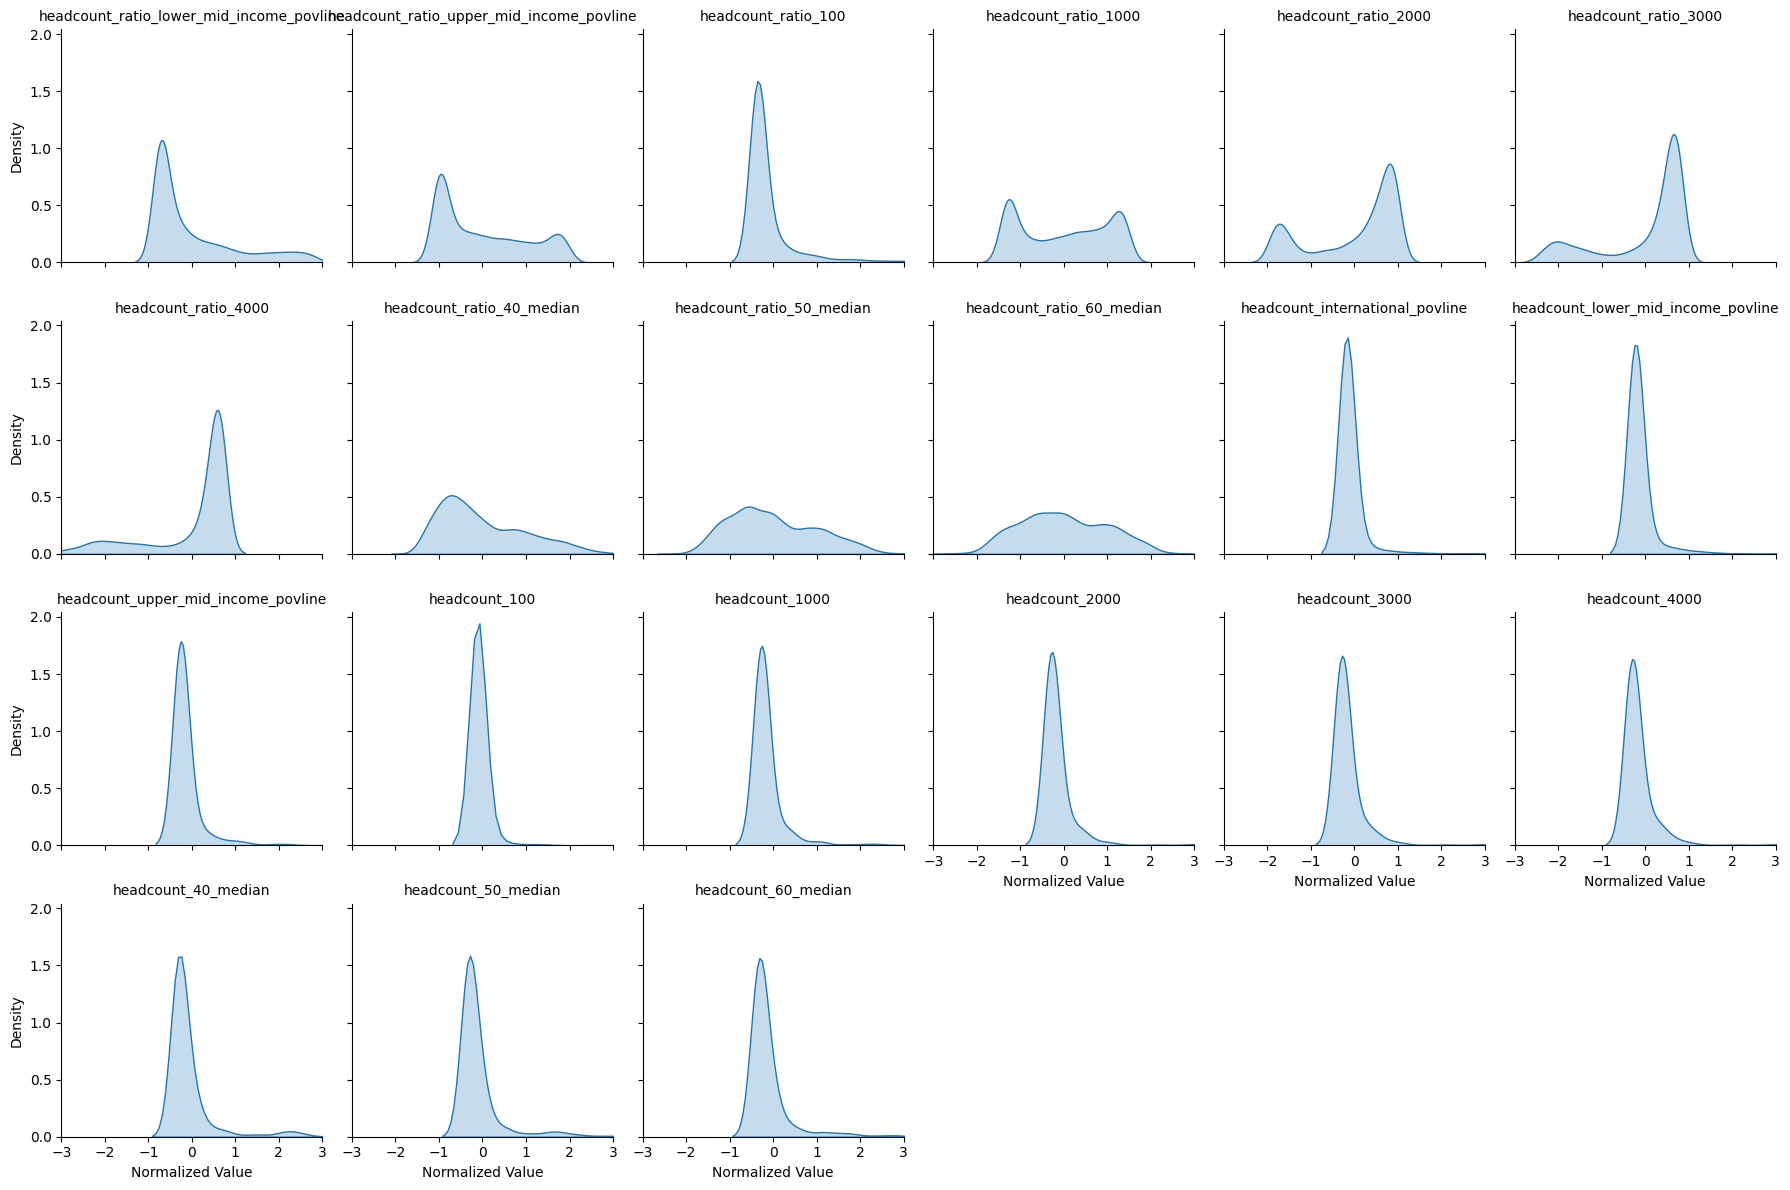

In [46]:
# Normalizar el dataset y transformarlo a formato largo
data_scaled = pd.DataFrame(StandardScaler().fit_transform(data_headcount), columns=data_headcount.columns)
data_melted = data_scaled.melt(var_name='variable', value_name='value')

# Crear el grid de KDE plots
g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
g.map(sns.kdeplot, "value", fill=True)

# Ajustar los límites del eje X y layout
g.set(xlim=(-3, 3))  # Ajuste de X para un rango más estrecho si los datos están normalizados
g.set_titles("{col_name}")
g.set_axis_labels("Normalized Value", "Density")
g.tight_layout()
plt.show()

In [47]:
# Function to replace outliers with NaN based on a 99% confidence interval
def replace_outliers_with_nan(df):
    transformed_df = df.copy()
    cells_replaced = 0  # Counter for cells turned to NaN

    for column in transformed_df.select_dtypes(include=[np.number]).columns:
        lower_limit = transformed_df[column].quantile(0.005)
        upper_limit = transformed_df[column].quantile(0.995)
        
        # Count the cells that will be set to NaN
        cells_replaced += transformed_df[(transformed_df[column] < lower_limit) | 
                                         (transformed_df[column] > upper_limit)][column].count()
        
        # Replace outliers with NaN
        transformed_df[column] = transformed_df[column].mask(
            (transformed_df[column] < lower_limit) | (transformed_df[column] > upper_limit), 
            np.nan
        )
        
    return transformed_df, cells_replaced

Outliers set to NaN in 'data': 4074


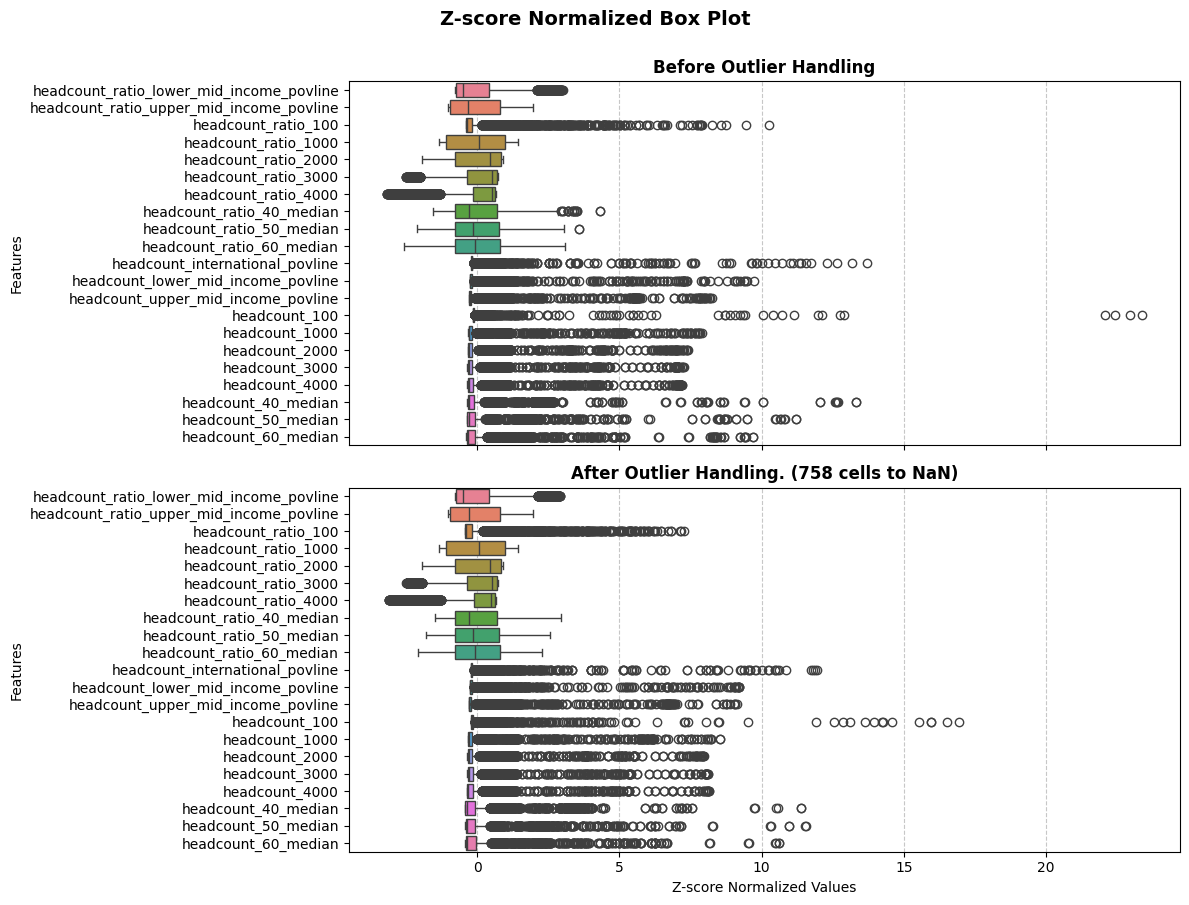

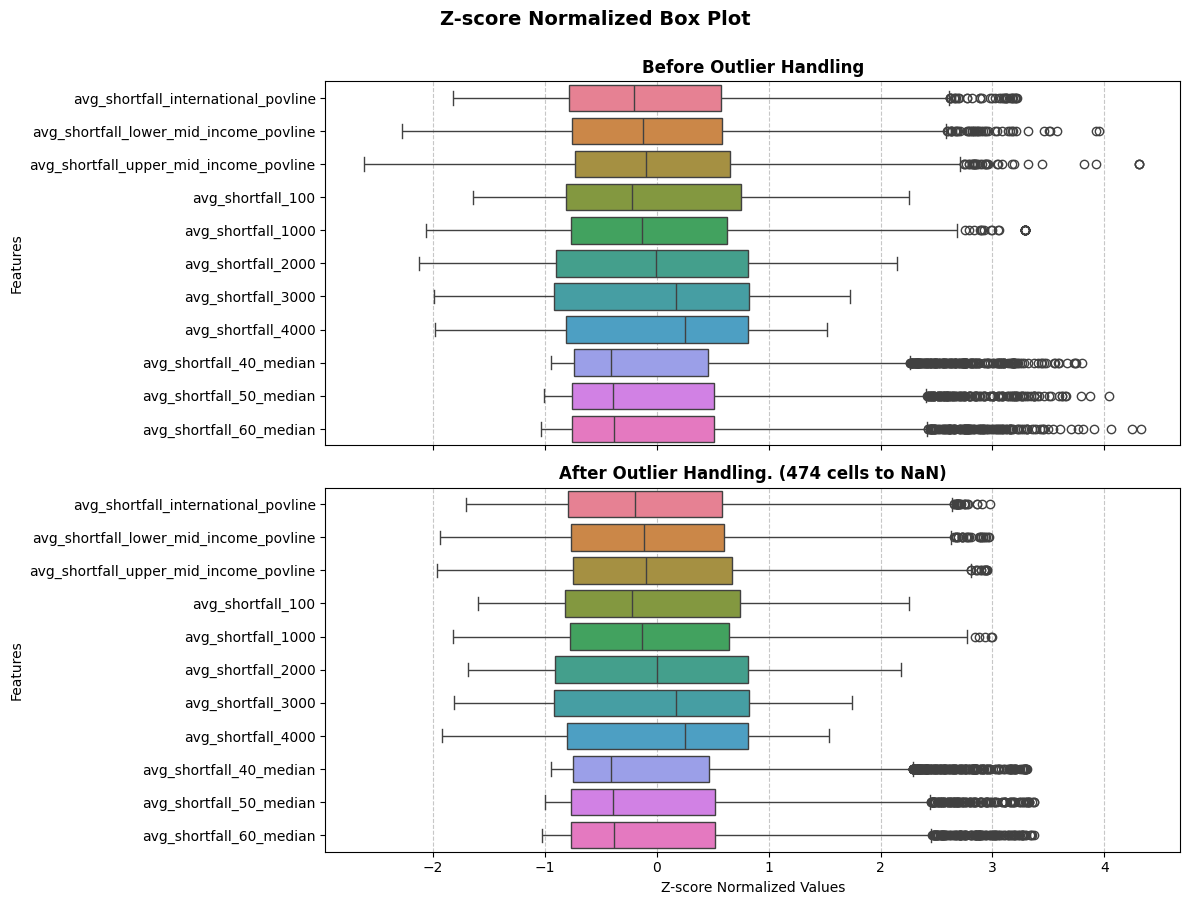

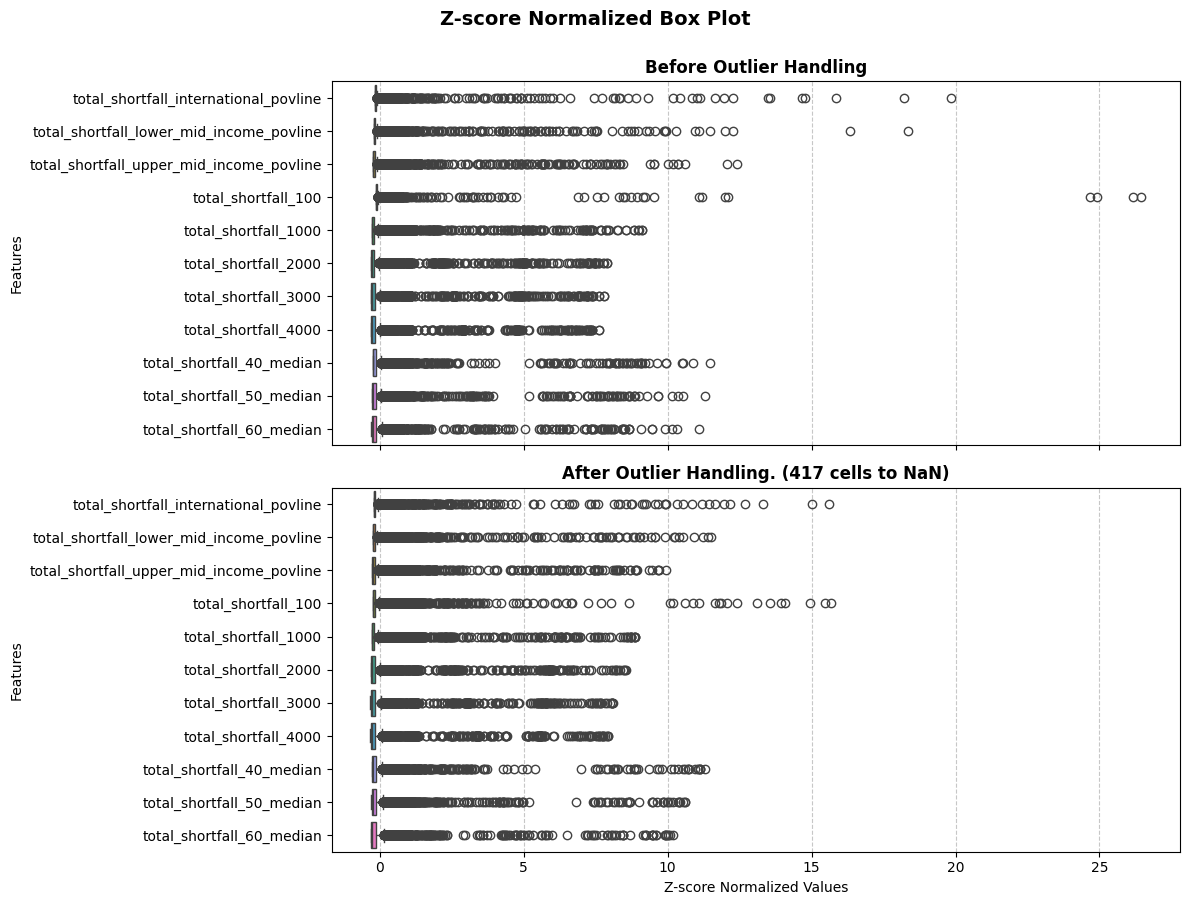

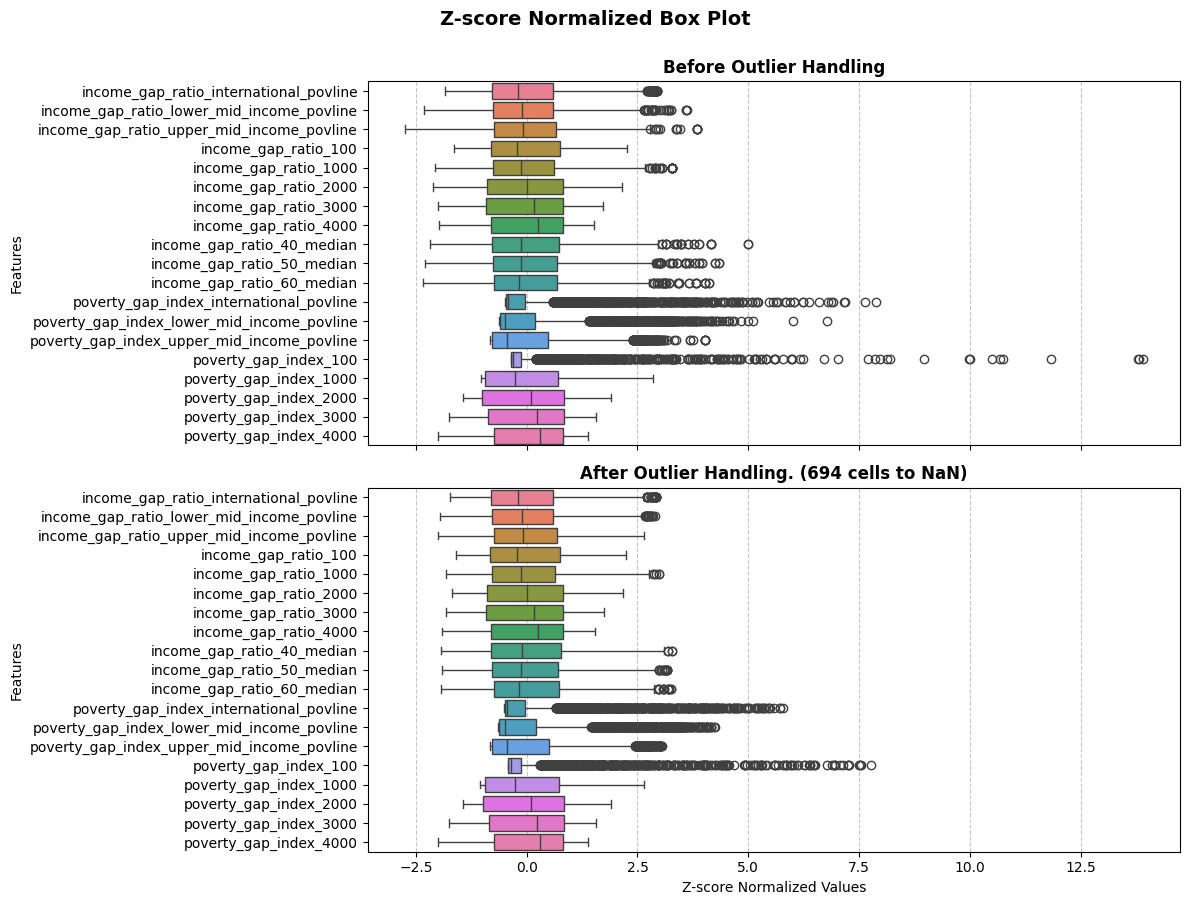

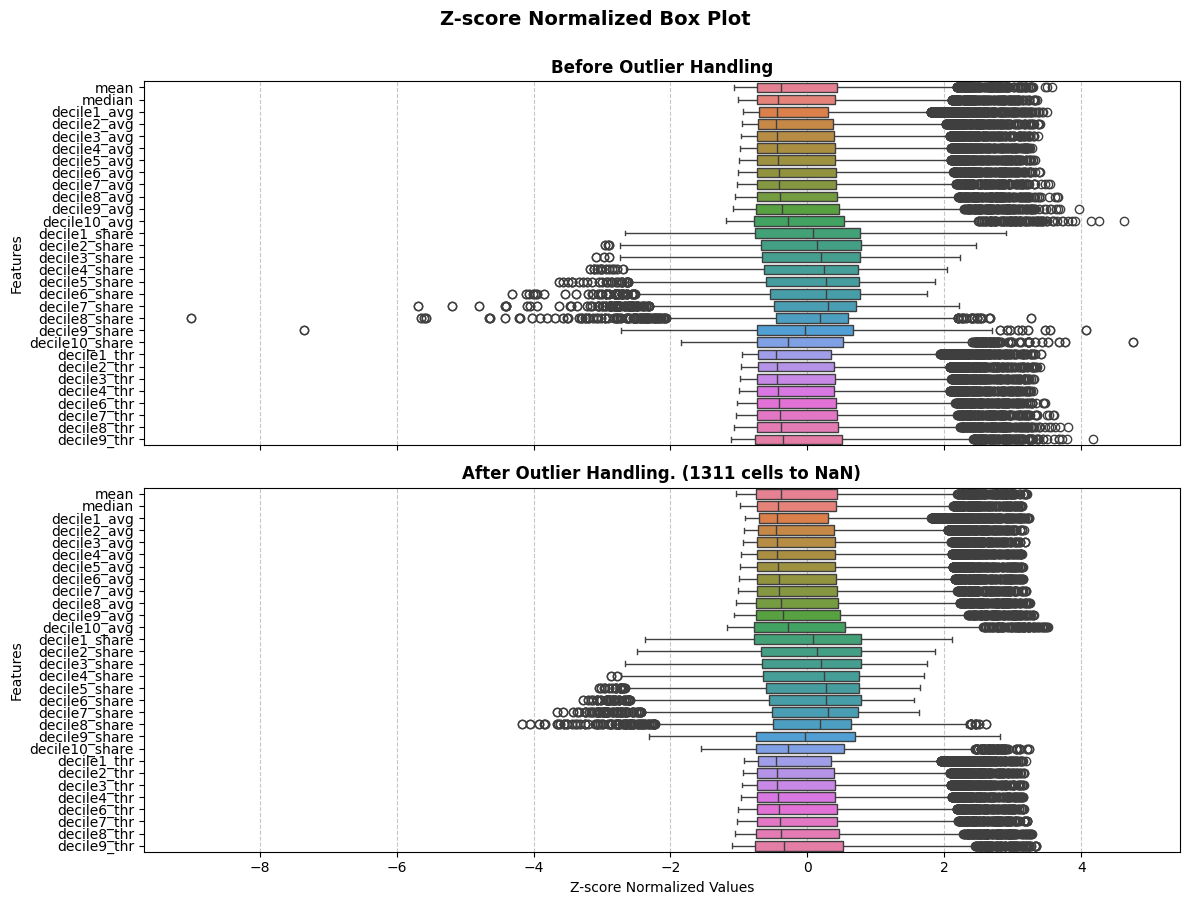

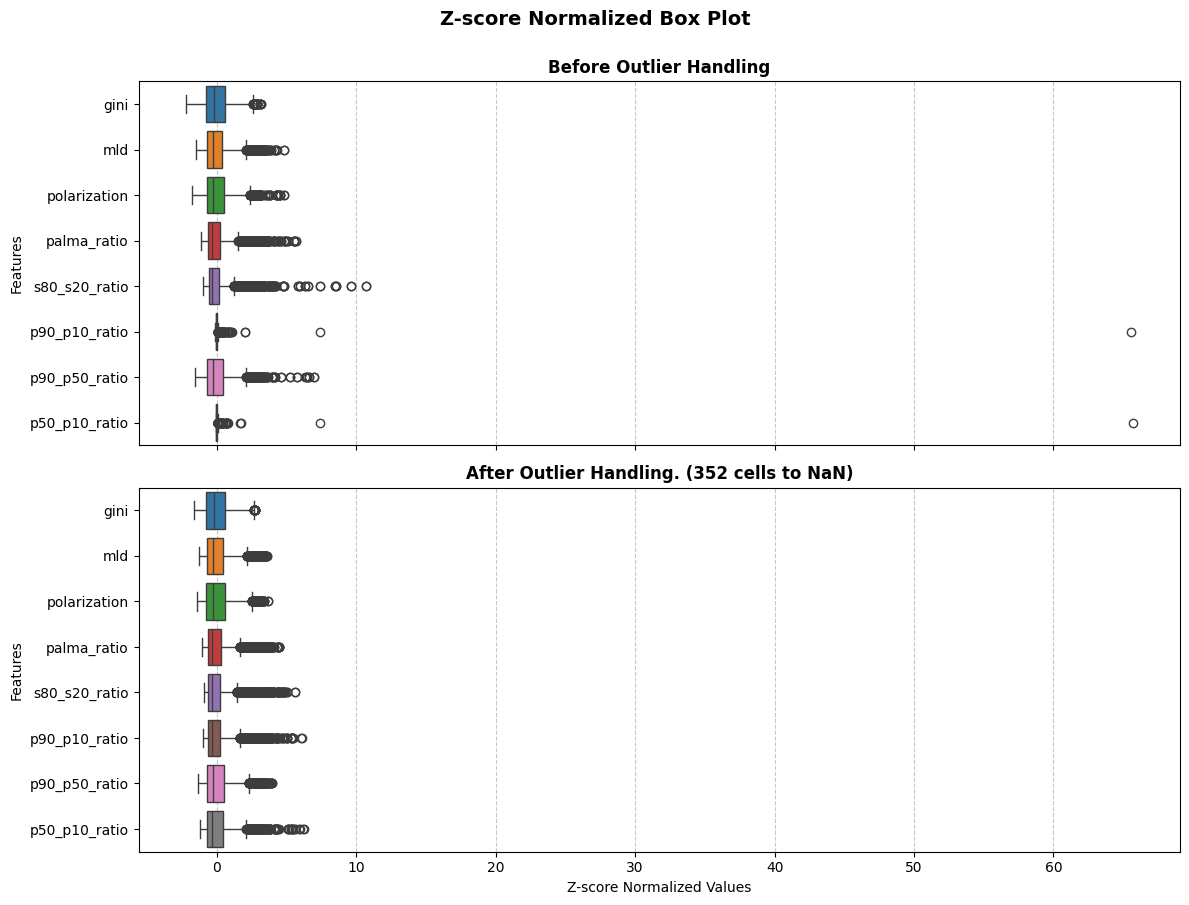

In [48]:
# Apply outlier handling to 'data'
data, data_outliers_replaced = replace_outliers_with_nan(data)

# Display the count of outliers replaced in 'data'
print(f"Outliers set to NaN in 'data': {data_outliers_replaced}")

# Apply outlier handling to each dataset in the dictionary and visualize with Z-score normalization
for name, dataset in datasets.items():
    # Normalize without handling outliers
    normalized_dataset_no_outliers = dataset.apply(zscore, nan_policy='omit')
    
    # Replace outliers with NaN in each dataset and normalize again
    datasets[name], cells_replaced = replace_outliers_with_nan(dataset)
    normalized_dataset_outliers_handled = datasets[name].apply(zscore, nan_policy='omit')
    
    # Create a figure with 2 subplots (one above the other) to compare before and after handling outliers
    fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    
    # Plot Z-score normalized dataset before outlier handling
    sns.boxplot(data=normalized_dataset_no_outliers, orient="h", ax=axes[0])
    axes[0].set_title(f"Before Outlier Handling", fontdict={'weight': 'bold', 'size': 12})
    axes[0].set_xlabel("Z-score Normalized Values")
    axes[0].set_ylabel("Features")
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Plot Z-score normalized dataset after outlier handling
    sns.boxplot(data=normalized_dataset_outliers_handled, orient="h", ax=axes[1])
    axes[1].set_title(f"After Outlier Handling. ({cells_replaced} cells to NaN)", fontdict={'weight': 'bold', 'size': 12})
    axes[1].set_xlabel("Z-score Normalized Values")
    axes[1].set_ylabel("Features")
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)

    
    # Adjust the layout and add suptitle
    plt.suptitle(f"Z-score Normalized Box Plot", y=1, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Imputar con MICE regresión lineal los missing restantes

In [49]:
# Solve numerical missing data
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)
data[feat_num] = imputer.fit_transform(data[feat_num])
data = data.reset_index(drop=True)

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [50]:
data_headcount = data.iloc[:, 7:29]
data_avg_shortfall = data.iloc[:, 29:40]
data_total_shortfall = data.iloc[:, 40:51]
data_income_poverty_gap = data.iloc[:, 51:70]
data_decile = data.iloc[:, 70:100]
data_end = data.iloc[:, 100:109]

datasets = {
    'Headcount': data_headcount,
    'Average_Shortfall': data_avg_shortfall,
    'Total_Shortfall': data_total_shortfall,
    'Income_Poverty_Gap': data_income_poverty_gap,
    'Deciles': data_decile,
    'Inequality_Metrics': data_end
}

### 3. Análisis de correlaciones y reducción de la dimensionalidad <a class="anchor" id="seccion_3"></a>


Realizar un análisis de correlaciones y obtener un gráfico de pareto tras PCA por subgrupos.

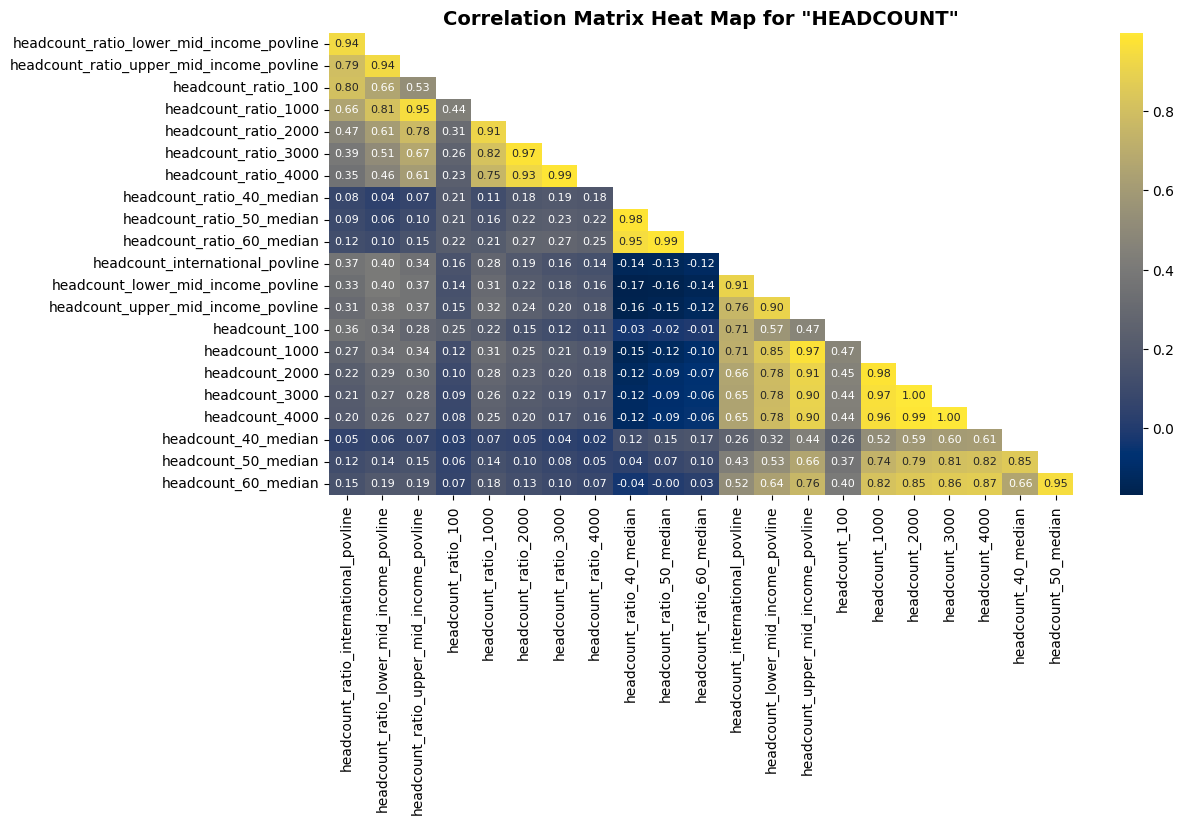

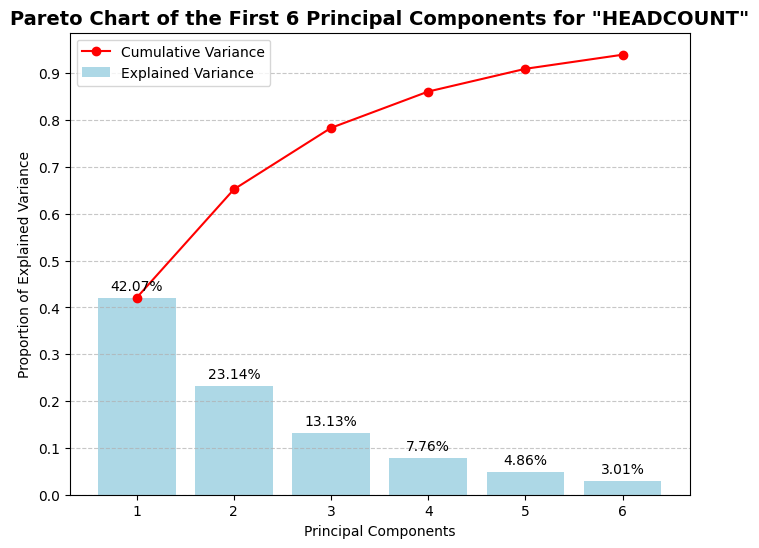

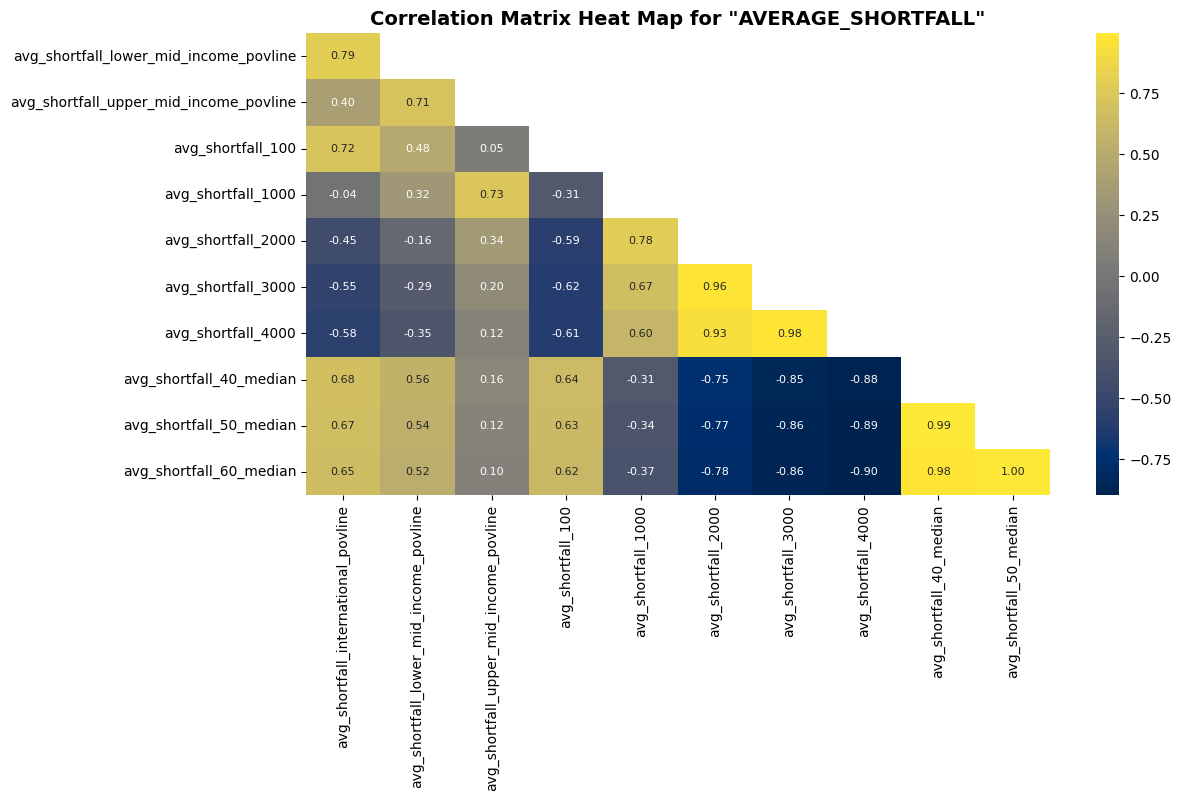

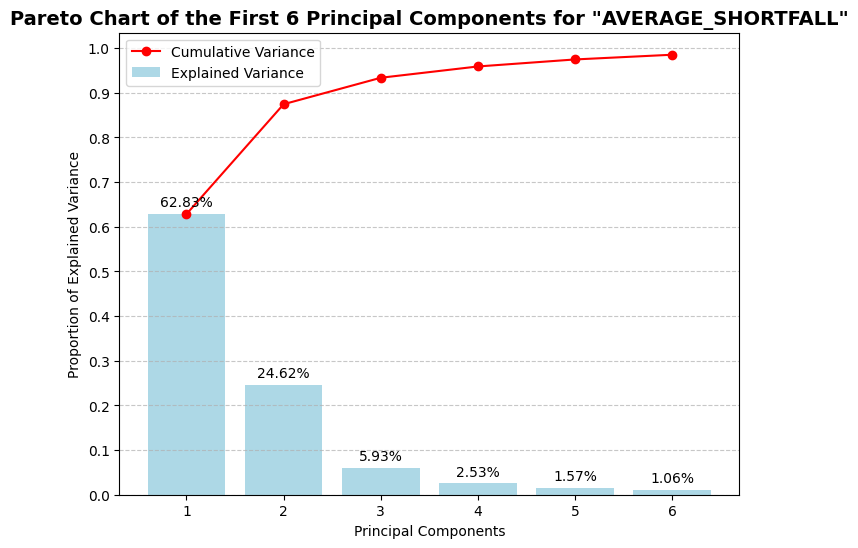

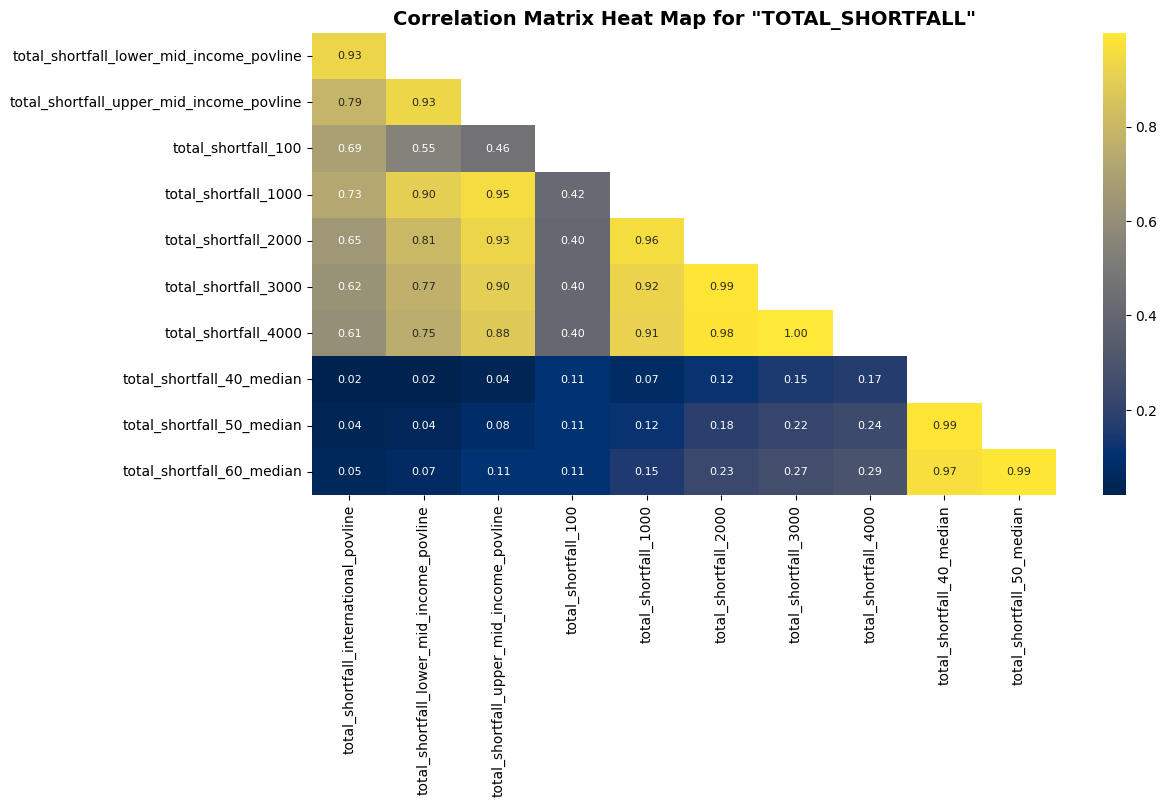

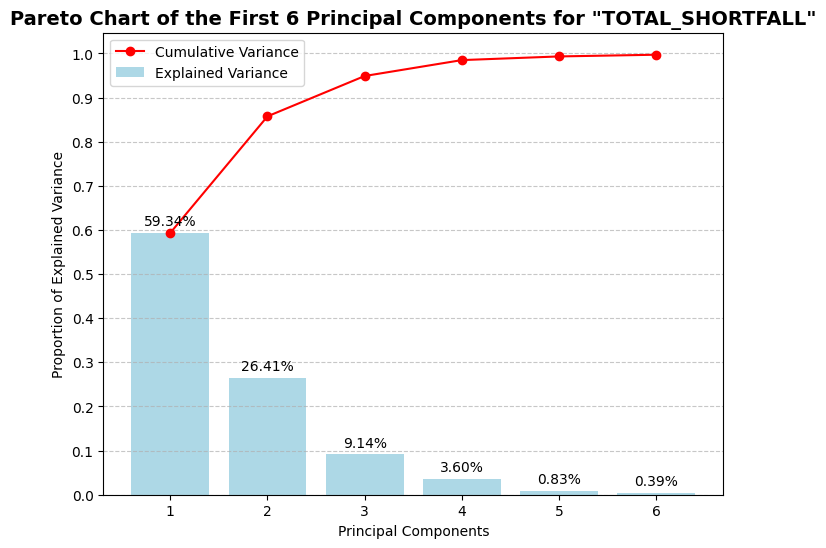

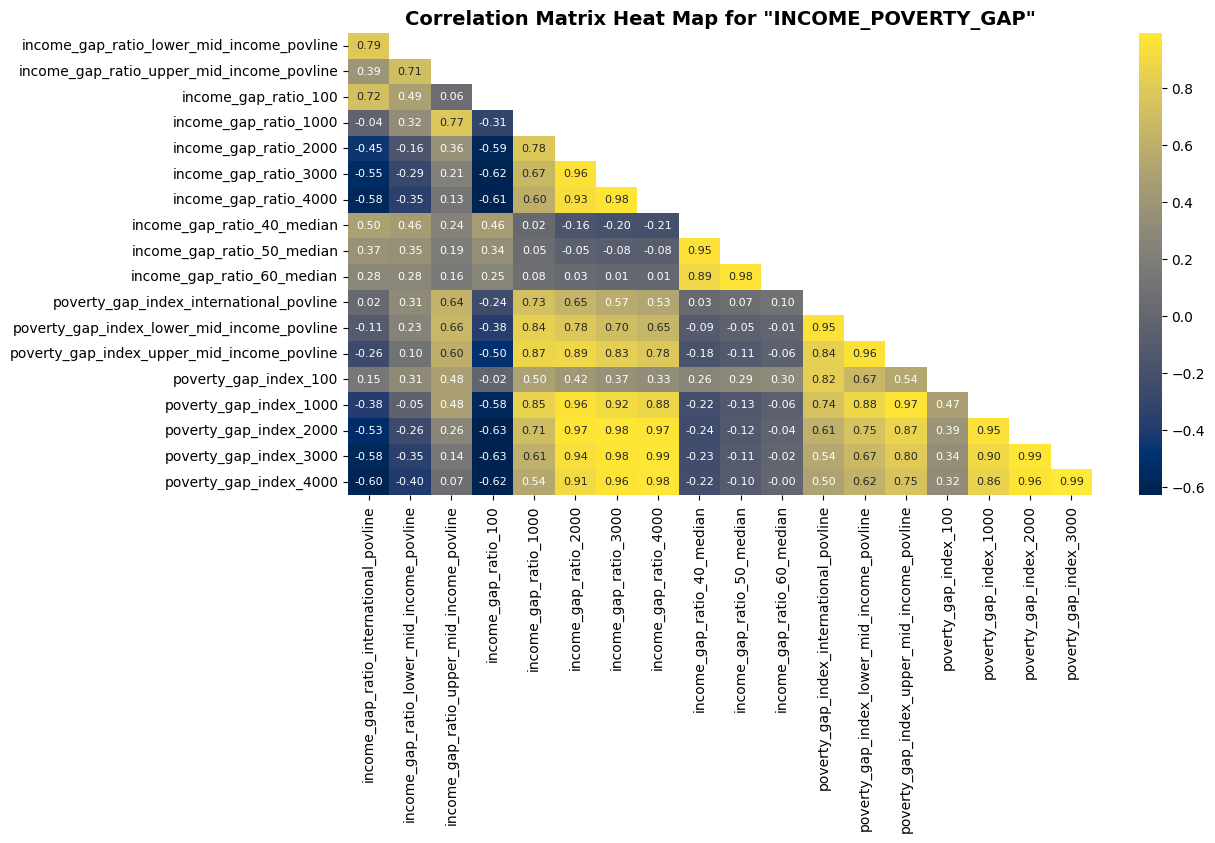

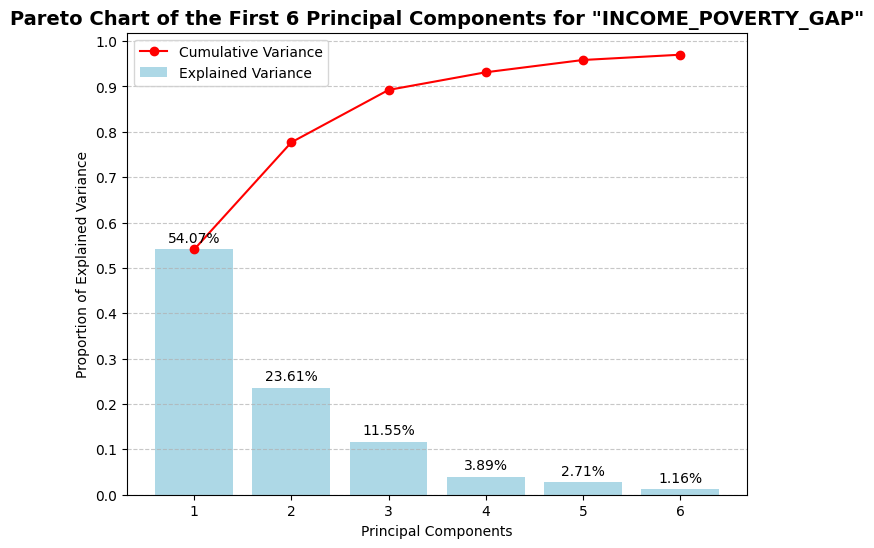

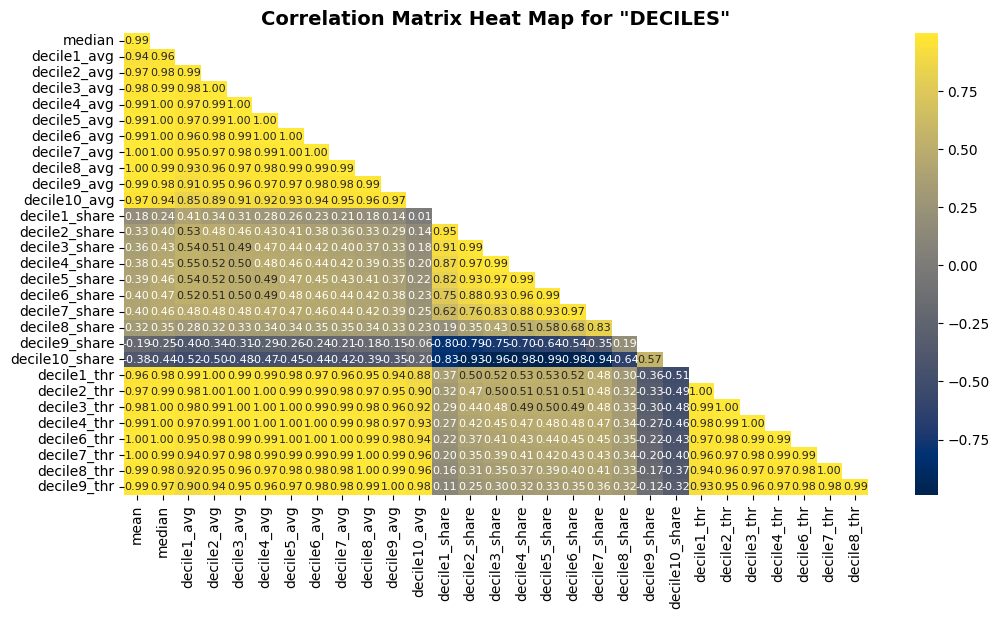

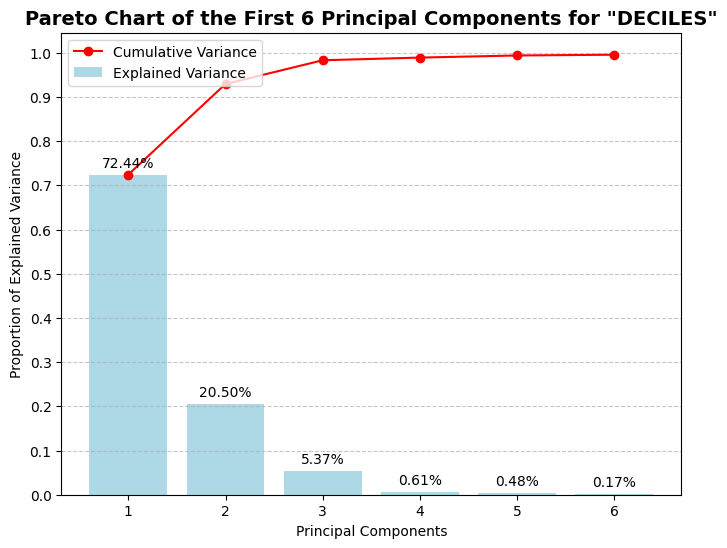

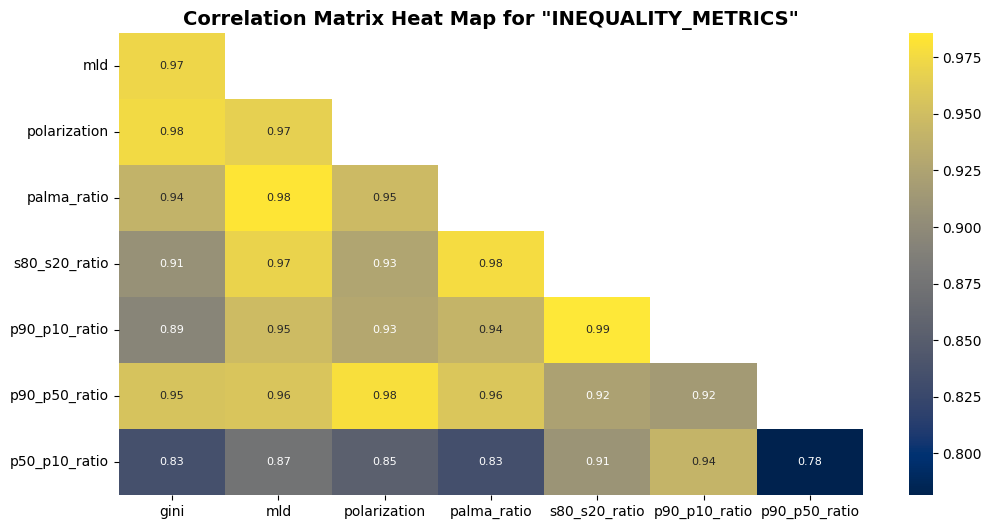

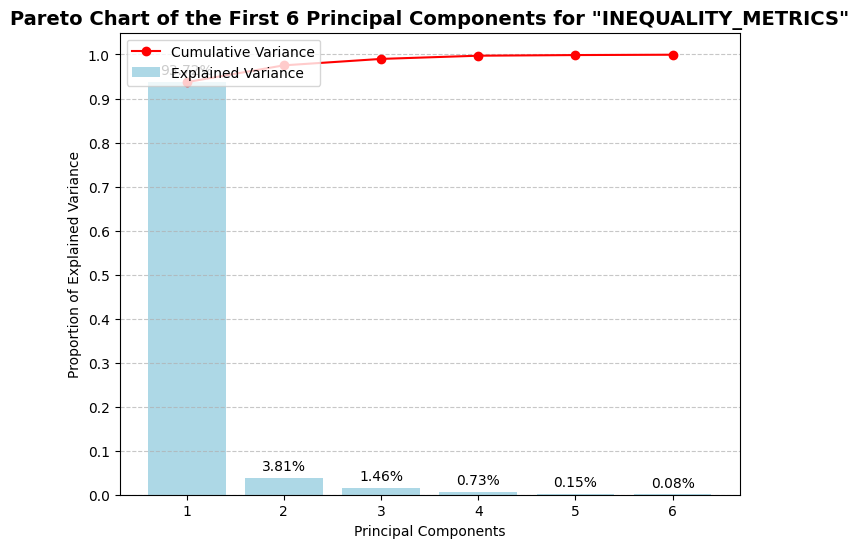

In [51]:
dataset_PCA = data.iloc[:, :7]

for name, dataset in datasets.items():

    ## CORRELATION MATRIX HEAT MAP
    corr_num = dataset.corr()
    mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f", cmap="cividis", annot_kws={"size": 8})
    plt.title(f'Correlation Matrix Heat Map for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.show()

    ## PCA & PARETO CHART
    # Standarise using Z-score
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(dataset)

    pca = PCA()
    pca_data = pca.fit_transform(data_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Select the first N components
    n_components = 6
    explained_variance_N = explained_variance[:n_components]
    cumulative_variance_N = np.cumsum(explained_variance_N)

    # Pareto Chart
    plt.figure(figsize=(8, 6))
    components = np.arange(1, n_components+1)

    # Explained and cumulative variance
    plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
    plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

    plt.xlabel("Principal Components")
    plt.ylabel("Proportion of Explained Variance")
    plt.title(f'Pareto Chart of the First {n_components} Principal Components for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})

    # Alabels with the percentage variability
    for i in range(len(components)):
        plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)
    
    plt.xticks(components)
    plt.legend(loc='upper left', title_fontsize='medium', prop={'size': 10})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
    plt.show()

    # Select and store the minimum number of components needed to reach 90% cumulative variance
    n_components_90 = np.argmax(cumulative_variance_N >= 0.90) + 1  # Number of components needed for 90%
    pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components_90)]
    dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components_90], columns=pca_columns)
    dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)

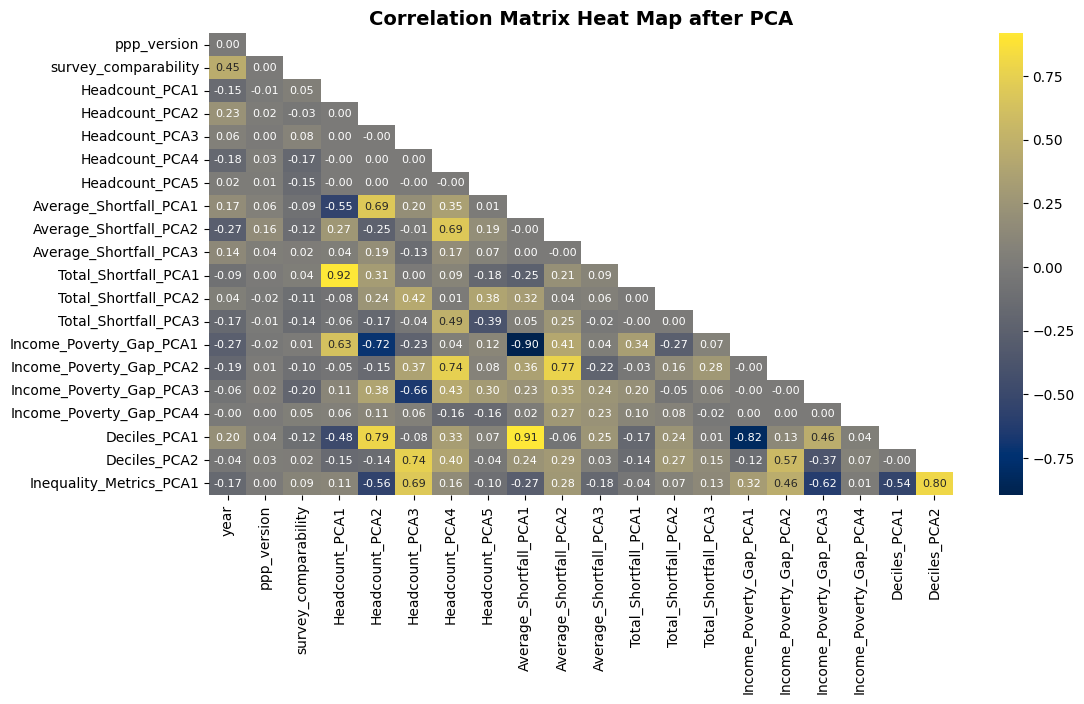

In [52]:
dataset_PCA
feat_names = dataset_PCA.columns
feat_num = [feat for feat in feat_names if feat not in feat_cat]

## CORRELATION MATRIX HEAT MAP
corr_num = dataset_PCA[feat_num].corr()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f", cmap="cividis", annot_kws={"size": 8})
plt.title(f'Correlation Matrix Heat Map after PCA', fontdict={'fontsize': 14, 'weight': 'bold'})
plt.show()

In [71]:
dataset_PCA.shape

(4395, 25)

In [68]:
dataset_PCA
dataset_PCA['continent'].count()
# dataset_PCA[dataset_PCA['continent'] == 'nan'].value_counts()

1738

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\carlo\AppData\Local\Temp\ipykernel_15480\186335007.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continent_data['Cluster'] = kmeans.fit_predict(X)


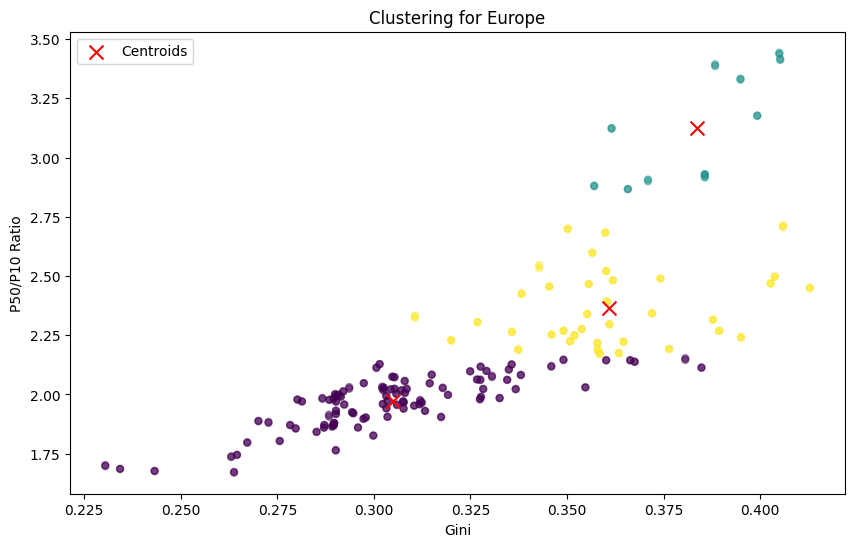

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by KMeans.

In [54]:
# Loop through each continent
for continent in dataset_PCA['continent'].unique():
    # Filter the dataset for the current continent
    continent_data = dataset_PCA[dataset_PCA['continent'] == continent]
    
    # Select relevant columns for clustering
    X = continent_data[['gini', 'p50_p10_ratio']]
    
    # Define the number of clusters (e.g., k = 3)
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Perform clustering and add the cluster labels to the dataset
    continent_data['Cluster'] = kmeans.fit_predict(X)
    
    # Visualize the scatter plot with clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(continent_data['gini'], continent_data['p50_p10_ratio'], 
                c=continent_data['Cluster'], cmap='viridis', s=25, alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=100, label='Centroids')
    plt.title(f"Clustering for {continent}")
    plt.xlabel("Gini")
    plt.ylabel("P50/P10 Ratio")
    plt.legend()
    plt.show()

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


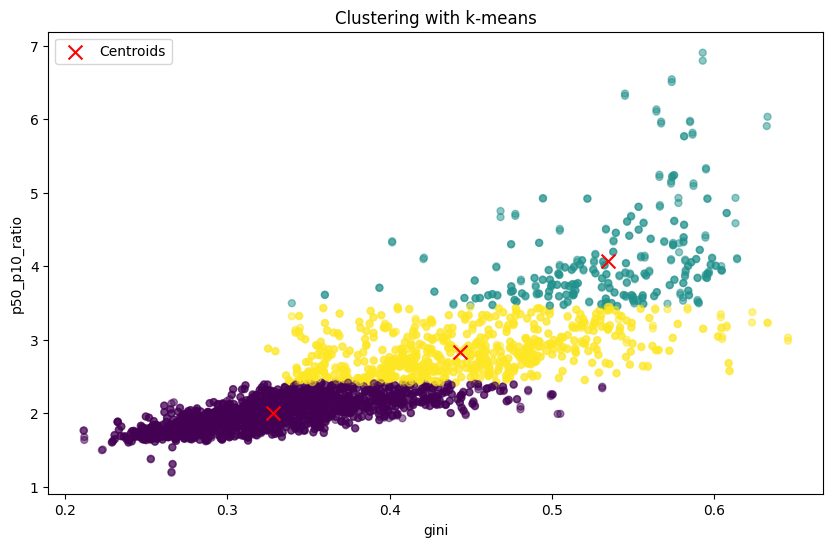

In [ ]:
# Si los datos ya están en 'df', seleccionamos las columnas relevantes
X = data[['gini', 'p50_p10_ratio']]

# Definimos el número de clusters (por ejemplo, k = 3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
dataset_PCA['Cluster'] = kmeans.fit_predict(X)  # Realizamos el clustering y asignamos las etiquetas al dataset

# Visualizamos el scatter plot con los clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['gini'], data['p50_p10_ratio'], c=dataset_PCA['Cluster'], cmap='viridis', s=25, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("Clustering with k-means")
plt.xlabel("gini")
plt.ylabel("p50_p10_ratio")
plt.legend()
plt.show()

In [ ]:
columns_delete = ["Headcount_PCA1","Average_Shortfall_PCA1"]

In [ ]:
feat_names = data.columns
feat_cat = [feat_names[0]] + list(feat_names[2:4])
feat_num = [feat for feat in feat_names if feat not in feat_cat]
dataset = data[feat_num]
dataset = dataset.iloc[:, :-8]
dataset

,continent,welfare_type,ppp_version,survey_comparability,headcount_ratio_international_povline,headcount_ratio_lower_mid_income_povline,headcount_ratio_upper_mid_income_povline,headcount_ratio_100,headcount_ratio_1000,headcount_ratio_2000,...,decile9_share,decile10_share,decile1_thr,decile2_thr,decile3_thr,decile4_thr,decile6_thr,decile7_thr,decile8_thr,decile9_thr
0,Europe,consumption,2011.0,0.0,0.920669,11.174149,44.618417,0.057416,86.175208,99.632079,...,14.899548,21.215573,3.06,3.88,4.48,5.16,6.66,7.61,8.85,10.92
1,Europe,consumption,2011.0,1.0,1.570843,14.132118,49.669635,0.046371,85.338317,98.080061,...,14.925078,25.435637,2.91,3.62,4.22,4.85,6.35,7.38,8.83,11.58
2,Europe,consumption,2011.0,1.0,0.860527,8.715685,38.545254,0.027620,79.987127,97.576598,...,14.833943,24.341168,3.30,4.18,4.93,5.63,7.32,8.51,10.02,12.78
3,Europe,consumption,2011.0,1.0,0.313650,5.250542,31.110345,0.000000,75.851021,97.099785,...,14.535204,24.458311,3.81,4.70,5.43,6.20,7.93,9.24,10.74,13.62
4,Europe,consumption,2011.0,1.0,0.849754,6.182414,34.528906,0.111321,77.069840,97.772626,...,14.889137,22.934340,3.65,4.49,5.17,5.93,7.74,8.91,10.52,13.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4390,Africa,consumption,2017.0,3.0,64.698028,81.165271,92.573347,33.916066,96.002132,99.070190,...,16.306544,43.161862,0.49,0.69,0.90,1.15,1.88,2.51,3.49,5.63
4391,Africa,consumption,2017.0,4.0,68.456606,82.885088,93.044964,36.476496,96.299710,99.003962,...,15.817647,45.232624,0.51,0.70,0.88,1.09,1.71,2.26,3.27,5.34
4392,Africa,consumption,2017.0,4.0,61.352160,77.548045,90.747141,34.330914,95.074710,98.777883,...,16.886786,44.380894,0.46,0.67,0.90,1.19,2.07,2.86,4.02,6.43
4393,NaN,consumption,2017.0,0.0,21.580063,47.857143,77.945113,0.351729,88.905316,97.352365,...,15.834337,33.830126,1.57,2.07,2.58,3.15,4.59,5.65,7.25,10.54


ANÁLISIS GLOBAL DE CORRELACIONES + PCA

In [ ]:

## CORRELATION MATRIX HEAT MAP
corr_num = dataset.corr()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(18, 10))  # Aumenta el tamaño del gráfico para acomodar más etiquetas
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=False, fmt=".2f", cmap="cividis", annot_kws={"size": 5})

# Configuración del título
plt.title('Correlation Matrix Heat Map', fontdict={'fontsize': 12, 'weight': 'bold'})

# Ajustar etiquetas de los ejes
plt.xticks(rotation=90, fontsize=10)  # Rotar las etiquetas del eje X y reducir el tamaño de fuente
plt.yticks(fontsize=10)  # Reducir el tamaño de fuente de las etiquetas del eje Y

plt.show()

## PCA & PARETO CHART
# Standarise using Z-score
scaler = StandardScaler()
data_standardized = scaler.fit_transform(dataset)

pca = PCA()
pca_data = pca.fit_transform(data_standardized)
explained_variance = pca.explained_variance_ratio_

# Select the first N components
n_components = 12
explained_variance_N = explained_variance[:n_components]
cumulative_variance_N = np.cumsum(explained_variance_N)

# Pareto Chart
plt.figure(figsize=(8, 6))
components = np.arange(1, n_components+1)

# Explained and cumulative variance
plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

plt.xlabel("Principal Components")
plt.ylabel("Proportion of Explained Variance")
plt.title(f'Pareto Chart of the First {n_components} Principal Components', fontdict={'fontsize': 14, 'weight': 'bold'})

# Alabels with the percentage variability
for i in range(len(components)):
    plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)

plt.xticks(components)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
plt.show()

# Select and store the minimum number of components needed to reach 90% cumulative variance
n_components_90 = np.argmax(cumulative_variance_N >= 0.90) + 1  # Number of components needed for 90%
pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components_90)]
dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components_90], columns=pca_columns)
dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)

ValueError: could not convert string to float: 'Europe'